### Working With ASDF Files

#### Outline

- Read a file
- Show the contents of an ASDF file
- Search for an attribute in an ASDF file
- Accessing metadata and data
- Modifying and saving files
- Exercise
- Adding History items
- Command line utilities

#### Reading an ASDF file

The Python ASDF library is a standalone package distributed through PyPi and conda-forge.

In [1]:
import asdf

To open a file use the `open` function. It is useful to look up the keyword arguments it accepts, there are options specifying in what mode a file should be opened or whether it should be validated during opening. For this example we will use the default behavior and look at the object.

In [2]:
af = asdf.open("pluto.asdf")
af

#### Getting information about a file

There are two functions that allow introspecting a file, `info` and `search`. They are available as methods on the `AsdfFile` object or and the command line interface. Both are configurable through multiple parameters.

In [3]:
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension.BuiltinExtension
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 2.12.0
│   └─[1] (ExtensionMetadata)
│     ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│     ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.5.0
│     └─software (Software)
│       ├─name (str): asdf-astropy
│       └─version (str): 0.2.1
├─birthday (date)
├─mass (Quantity): shape=(), dtype=float64
├─name (str): Pluto
└─picture (NDArrayType): shape=(333, 151, 4), dtype=float32


The asdf library has search capabilities. A file can be searched for an attribute by name, type or value.

In [4]:
af.search("birthday")

root (AsdfObject)
└─birthday (date)

In [5]:
af.search(value="Pluto")

root (AsdfObject)
└─name (str): Pluto

`astropy` supports units and quantities. A `Quantity` is a value (scalar or array) with units attached to it. Let's searvh by type `Quantity`.

In [6]:
from astropy import units as u

af.search(type=u.Quantity)

root (AsdfObject)
└─mass (Quantity): shape=(), dtype=float64

#### Accessing and Modifying a file

Attributes are accessed using a dict-like interface. Note that what we get below is a `Quantity` object.

In [7]:
weight = af["mass"]
print(weight)

10.0 kg


In [8]:
type(weight)

astropy.units.quantity.Quantity

#### Using a schema to validate a file

ASDF uses schemas to check that a file conforms to the [ASDF Standard](https://asdf-standard.readthedocs.io/en/latest/) and possibly the requirements of other extensions (see later notebooks). `jsonschema` is used for validation. Schema validation happens on reading (`asdf.open`) and writing (`write_to` and `update`). 

However, sometimes it is useful for particular applications to impose additional restrictions when deciding whether a given file is valid or not. ASDF allows using "custom schemas" in such cases and passing them to the `open` function.


Let's see how to write a schema and make sure our file `pluto.asdf` is correct.
A schema is just a text file and and any editor can be used to write it.

- There's a yaml header at the begining of each schema which states the version of the YAML schema, followed by `---` and the `$schema` declaration stating the draft.
- A schema file ends with `...` .
- The ASDF schemas use indentation, similar to YAML, and by convention it is 2 spaces.
- `title` is not required but by convention it's a one-line description of an attribute, printed as a comment by `info()`.
- `description` is an optional, longer, possibly multi-line comment.
- `type` is required
- If a `required` field is present, all properties listed in it must be present in the file.


In [9]:
s = """
%YAML 1.1
---
$schema: http://stsci.edu/schemas/yaml-schema/draft-01

title: Mickey's pet
description: |
  Basic info and a picture of Mickie's 
  dog Pluto.

type: object
properties:
  age:
    title: The age of Pluto
    type: object
    properties:
      birthday:
        title: Pluto's first showing
        tag: tag:stsci.edu:asdf/time/time-1.1.0
  mass:
    title: How much he weighs.
    tag: tag:stsci.edu:asdf/unit/quantity-1.1.0
  picture:
    tag: tag:stsci.edu:asdf/core/ndarray-1.0.0
  name:
    title: Name
    type: string
required: [name, picture]
...
"""

In [10]:
f = open("pluto-1.0.0.yaml", mode="w")
f.write(s)
f.close()

In [11]:
afs = asdf.open("pluto.asdf", custom_schema="./pluto-1.0.0.yaml")

#### Adding History items

When using `asdf.info` we see one of the properties is called `History`. By default it stores a list of extensions used when processing the file. It is possible to add custom entries to this list.

In [12]:
afs.add_history_entry('First appeared in "The Chain Gang", 1930')

In [13]:
afs.info(max_rows=30)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ ├─extensions (list)
│ │ ├─[0] (ExtensionMetadata)
│ │ │ ├─extension_class (str): asdf.extension.BuiltinExtension
│ │ │ └─software (Software)
│ │ │   ├─name (str): asdf
│ │ │   └─version (str): 2.12.0
│ │ └─[1] (ExtensionMetadata)
│ │   ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│ │   ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.5.0
│ │   └─software (Software)
│ │     ├─name (str): asdf-astropy
│ │     └─version (str): 0.2.1
│ └─entries (list)
│   └─[0] (HistoryEntry)
│     ├─description (str): First appeared in "The Chain Gang", 1930
│     └─time (datetime)
├─birthday (date)
├─mass (Quantity): shape=(), dtype=float64
├─name (str): Pluto
└─picture (NDArrayType): shape=(333, 151, 4), dtype=float32


In [14]:
afs.get_history_entries()

[{'description': 'First appeared in "The Chain Gang", 1930',
  'time': datetime.datetime(2022, 7, 11, 13, 39, 49)}]

**Command Line Interface**

The library, asdf, includes a command-line tool, asdftool that performs a number of useful operations:

**explode:** Convert a self-contained ASDF file into exploded form (see Saving external arrays).

**implode:** Convert an ASDF file in exploded form into a self-contained file.

**defragment:** Remove unused blocks and extra space.

**diff:** Report differences between two ASDF files.

**edit:** Edit the YAML portion of an ASDF file.

**info:** Print a rendering of an ASDF tree.

**extensions:** Show information about installed extensions (see Extensions from other packages).

**tags:** List currently available tags.

**to_yaml:** Inline all of the data in an ASDF file so that it is pure YAML.

Run `asdftool --help` for more information.

In [15]:
!asdftool --help

usage: asdftool [-h] [--verbose]
                {help,explode,implode,extract,defragment,diff,edit,remove-hdu,info,extensions,tags,to_yaml}
                ...

Commandline utilities for managing ASDF files.

optional arguments:
  -h, --help            show this help message and exit
  --verbose, -v         Increase verbosity

subcommands:
  valid subcommands

  {help,explode,implode,extract,defragment,diff,edit,remove-hdu,info,extensions,tags,to_yaml}
    help                Display usage information
    explode             Explode a ASDF file.
    implode             Implode a ASDF file.
    extract             Extract ASDF extensions in ASDF-in-FITS files into
                        pure ASDF files
    defragment          Defragment an ASDF file..
    diff                Report differences between two ASDF files
    remove-hdu          Remove ASDF extension from ASDF-in-FITS file
    info                Print a rendering of an ASDF tree.
    extensions          Show information ab

--- 

**Exercises:**

 1. Reading and accessing data
 
    - Open the file `jwst.asdf` in the `02_Working_With_ASDF_Files` directory. Look at the `info` method's help and   display the file using some of the arguments to show more contents.
    - Search for a few attributes - `wcs`, `data`
      (`wcs` stands for World Coordinate System. In astronomy it represents the transform from pixel coordinates to sky coordinates or some physical system.)
    - Retrieve the `wcs` object following the path showed by the `search` method
    - Look at the `wcs` object and print `wcs.forward_transform`
    - Use matplotlib to display the data array
    - Look at the `data` array and modify the value of `data[0, 0]`  to 999.

    


 2. Explore schemas

   - Add `additionalProperties=false` to the schema and attempt to add a new property.
   - Modify the schema to include a required property, called `friend` of type string. 
   - Open the file to see the error message


 3. Command line tool

   - Use `asdftool` in a terminal window to find the differences in the two files - `pluto.asdf` and `pluto-friend.asdf`.

   - Use some of the other options of asdftool
   
---

In [56]:
jwst = asdf.open("jwst.asdf", mode="rw")
jwst

In [57]:
jwst.info(max_rows=55)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata) ...
│   ├─[1] (ExtensionMetadata) ...
│   ├─[2] (ExtensionMetadata) ...
│   ├─[3] (ExtensionMetadata) ...
│   └─[4] (ExtensionMetadata) ...
├─data (NDArrayType): shape=(333, 151, 4), dtype=float32
└─meta (dict)
  ├─aperture (dict)
  │ └─name (str): NRCB3_FULL
  ├─bunit_data (str): DN/s
  ├─bunit_err (str): DN/s
  ├─cal_step (dict)
  │ ├─assign_wcs (str): COMPLETE
  │ ├─dark_sub (str): COMPLETE
  │ ├─dq_init (str): COMPLETE
  │ ├─gain_scale (str): SKIPPED
  │ ├─group_scale (str): SKIPPED
  │ ├─ipc (str): COMPLETE
  │ ├─jump (str): COMPLETE
  │ ├─linearity (str): COMPLETE
  │ ├─ramp_fit (str): COMPLETE
  │ ├─refpix (str): COMPLETE
  │ ├─saturation (str): COMPLETE
  │ └─superbias (str): COMPLETE
  ├─calibration_software_revision (str): RELE

In [58]:
jwst.info?

Signature:
jwst.info(
    max_rows=24,
    max_cols=120,
    show_values=True,
    refresh_extension_manager=False,
)
Docstring:
Print a rendering of this file's tree to stdout.

Parameters
----------
max_rows : int, tuple, or None, optional
    Maximum number of lines to print.  Nodes that cannot be
    displayed will be elided with a message.
    If int, constrain total number of displayed lines.
    If tuple, constrain lines per node at the depth corresponding                 to the tuple index.
    If None, display all lines.

max_cols : int or None, optional
    Maximum length of line to print.  Nodes that cannot
    be fully displayed will be truncated with a message.
    If int, constrain length of displayed lines.
    If None, line length is unconstrained.

show_values : bool, optional
    Set to False to disable display of primitive values in
    the rendered tree.
File:      ~/miniconda3/envs/asdf-tutorial-env/lib/python3.9/site-packages/asdf/asdf.py
Type:      method


In [59]:
jwst.search("wcs")

root (AsdfObject)
└─meta (dict)
  ├─cal_step (dict)
  │ └─assign_wcs (str): COMPLETE
  ├─ref_file (dict)
  │ └─specwcs (dict)
  ├─wcs (WCS)
  └─wcsinfo (dict)
    ├─wcsaxes (int): 2
    └─wcsname (str): world

In [60]:
jwst.search("data")

root (AsdfObject)
├─data (NDArrayType): shape=(333, 151, 4), dtype=float32
└─meta (dict)
  └─bunit_data (str): DN/s

In [61]:
jwst["meta"]["wcs"]

<WCS(output_frame=world, input_frame=detector, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('lon', 'lat')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] & [5] | [6] | [7] & [8] | [9] | [10] & [11] | [12] & [13] | [14] | [15] & [16] | [17] | [18] | [19]
Components: 
    [0]: <Shift(offset=1.016)>

    [1]: <Shift(offset=1.625)>

    [2]: <Shift(offset=1.)>

    [3]: <Shift(offset=1.)>

    [4]: <Shift(offset=-1024.5)>

    [5]: <Shift(offset=-1024.5)>

    [6]: <Mapping((0, 1, 0, 1))>

    [7]: <Polynomial2D(5, c0_0=0., c1_0=0.03082914, c2_0=-0.00000006, c3_0=0., c4_0=-0., c5_0=0., c0_1=0., c0_2=0.00000001, c0_3=-0., c0_4=-0., c0_5=0., c1_1=-0.00000016, c1_2=0., c1_3=-0., c1_4=-0., c2_1=0., c2_2=-0., c2_3=-0., c3_1=0., c3_2=-0., c4_1=0.)>

    [8]: <Polynomial2D(5, c0_0=0., c1_0=0.00002005, c2_0=0.00000009, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.03091744, c0_2=-0.00000008, c0_3=0., c0_4=0., c0_5=-0., c1_1=-0.00000008, c1_2=-0., c1_3=-0., c1_4=0., c2_1=0.,

In [62]:
jwst["meta"]["wcs"].forward_transform

<CompoundModel(offset_0=1.016, offset_1=1.625, offset_2=1., offset_3=1., offset_4=-1024.5, offset_5=-1024.5, c0_0_7=0., c1_0_7=0.03082914, c2_0_7=-0.00000006, c3_0_7=0., c4_0_7=-0., c5_0_7=0., c0_1_7=0., c0_2_7=0.00000001, c0_3_7=-0., c0_4_7=-0., c0_5_7=0., c1_1_7=-0.00000016, c1_2_7=0., c1_3_7=-0., c1_4_7=-0., c2_1_7=0., c2_2_7=-0., c2_3_7=-0., c3_1_7=0., c3_2_7=-0., c4_1_7=0., c0_0_8=0., c1_0_8=0.00002005, c2_0_8=0.00000009, c3_0_8=0., c4_0_8=0., c5_0_8=-0., c0_1_8=0.03091744, c0_2_8=-0.00000008, c0_3_8=0., c0_4_8=0., c0_5_8=-0., c1_1_8=-0.00000008, c1_2_8=-0., c1_3_8=-0., c1_4_8=0., c2_1_8=0., c2_2_8=0., c2_3_8=-0., c3_1_8=0., c3_2_8=-0., c4_1_8=0., c0_0_10=0., c1_0_10=-0.99996951, c0_1_10=-0.0078089, c0_0_11=0., c1_0_11=-0.0078089, c0_1_11=0.99996951, offset_12=-54.5598065, offset_13=-457.731149, factor_15=0.00027778, factor_16=0.00027778, angles_18=[ -0.01476109,   0.12717271,   0.03968835, -69.48689121, -80.51050556])>

In [63]:
data = jwst["data"]
data

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

In [64]:
data.shape

(333, 151, 4)

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
data.shape[-1]

4

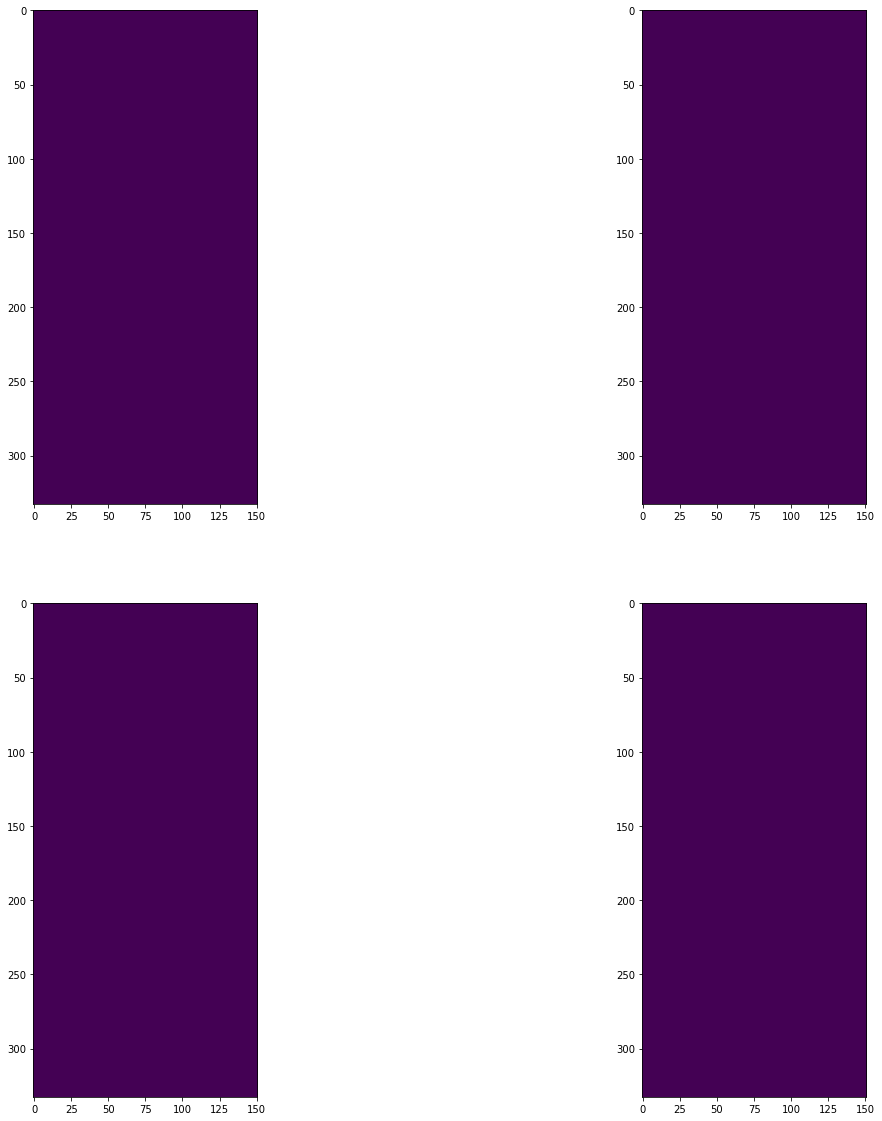

In [71]:
fig = plt.figure(figsize=(20, 20))
for i in range(data.shape[-1]):
    plt.subplot(2, 2, i + 1)
    plt.imshow(data[:, :, i])

In [69]:
jwst["data"][0, 0] = 999

In [70]:
jwst["data"]

array([[[999., 999., 999., 999.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        ...,
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.]],

       [[  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        ...,
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.]],

       [[  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        ...,
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.]],

       ...,

       [[  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        ...,
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.]],

       [[  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        .

In [53]:
s = """
%YAML 1.1
---
$schema: http://stsci.edu/schemas/yaml-schema/draft-01

title: Mickey's pet
description: |
  Basic info and a picture of Mickie's 
  dog Pluto.

type: object
properties:
  age:
    title: The age of Pluto
    type: object
    properties:
      birthday:
        title: Pluto's first showing
        tag: tag:stsci.edu:asdf/time/time-1.1.0
  mass:
    title: How much he weighs.
    tag: tag:stsci.edu:asdf/unit/quantity-1.1.0
  picture:
    tag: tag:stsci.edu:asdf/core/ndarray-1.0.0
  name:
    title: Name
    type: string
required: [name, picture]
...
"""

In [54]:
f = open("pluto-1.0.2.yaml", mode="w")
f.write(s)
f.close()

In [55]:
afs = asdf.open("pluto.asdf", custom_schema="./pluto-1.0.1.yaml")

ValidationError: Additional properties are not allowed ('history', 'birthday', 'asdf_library' were unexpected)

Failed validating 'additionalProperties' in schema:
    {'$schema': 'http://stsci.edu/schemas/yaml-schema/draft-01',
     'additionalProperties': False,
     'description': "Basic info and a picture of Mickie's \ndog Pluto.\n",
     'properties': {'age': {'properties': {'birthday': {'tag': 'tag:stsci.edu:asdf/time/time-1.1.0',
                                                        'title': "Pluto's "
                                                                 'first '
                                                                 'showing'}},
                            'title': 'The age of Pluto',
                            'type': 'object'},
                    'mass': {'tag': 'tag:stsci.edu:asdf/unit/quantity-1.1.0',
                             'title': 'How much he weighs.'},
                    'name': {'title': 'Name', 'type': 'string'},
                    'picture': {'tag': 'tag:stsci.edu:asdf/core/ndarray-1.0.0'}},
     'required': ['name', 'picture'],
     'title': "Mickey's pet",
     'type': 'object'}

On instance:
    {'asdf_library': {'author': 'The ASDF Developers',
                      'homepage': 'http://github.com/asdf-format/asdf',
                      'name': 'asdf',
                      'version': '2.12.0'},
     'birthday': datetime.date(1930, 8, 17),
     'history': {'extensions': [{'extension_class': 'asdf.extension.BuiltinExtension',
                                 'software': {'name': 'asdf',
                                              'version': '2.12.0'}},
                                {'extension_class': 'asdf.extension._manifest.ManifestExtension',
                                 'extension_uri': 'asdf://asdf-format.org/core/extensions/core-1.5.0',
                                 'software': {'name': 'asdf-astropy',
                                              'version': '0.2.1'}}]},
     'mass': {'unit': 'kg', 'value': 10.0},
     'name': 'Pluto',
     'picture': {'byteorder': 'little',
                 'datatype': 'float32',
                 'shape': [333, 151, 4],
                 'source': 0}}